In [1]:
import os
import torch

os.environ["MKL_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["OMP_NUM_THREADS"]="1"

import sys
import json

import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from spatial.merfish_dataset import FilteredMerfishDataset, MerfishDataset, SyntheticDataset0, SyntheticDataset1, SyntheticDataset2, SyntheticDataset3
from spatial.models.monet_ae import MonetAutoencoder2D, TrivialAutoencoder, MonetDense
from spatial.train import train
from spatial.predict import test

# makes the notebook loadable
import warnings
warnings.filterwarnings('ignore')

In [10]:
import hydra
from hydra.experimental import compose, initialize

test_loss_rad_dict = {}
for rad in range(0, 65, 5):
    for synthetic_exp in range(1):
#     for synthetic_exp in range(10):
        test_loss_rad_dict[str((rad, synthetic_exp))] = {}
        for model_architecture in [[128,128,128],[512],[512,512,512]]:
            with initialize(config_path=f"../../config"):
                cfg_from_terminal = compose(config_name=f"config{synthetic_exp}")
                print(rad, synthetic_exp, model_architecture)
                OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", model_architecture)
                OmegaConf.update(cfg_from_terminal, "training.logger_name", f"synthetic{synthetic_exp}")
                OmegaConf.update(cfg_from_terminal, "radius", rad)
                OmegaConf.update(cfg_from_terminal, "model.kwargs.response_genes", [0])
                OmegaConf.update(cfg_from_terminal, "datasets.dataset.splits", 0)
                output = test(cfg_from_terminal)
                trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
                test_loss_rad_dict[str((rad, synthetic_exp))][str(model_architecture)] = test_results[0]['test_loss']

            with open('../deepST_synthetic_results.json', 'w') as deepST:
                json.dump(test_loss_rad_dict, deepST)

0 0


100%|██████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.06it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.2349183245659788
     test_loss: mse         0.2349183245659788
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0 0


100%|██████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.08it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.23526116386767382
     test_loss: mse         0.23526116386767382
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0 0


100%|██████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.06it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.23508227563265396
     test_loss: mse         0.23508227563265396
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
5 0


100%|██████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.08it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.23455687614355186
     test_loss: mse         0.23455687614355186
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
5 0


100%|██████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.06it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.23503592545203633
     test_loss: mse         0.23503592545203633
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
5 0


100%|██████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.08it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.23506569580999115
     test_loss: mse         0.23506569580999115
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
10 0


100%|██████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.04it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.22880234586066506
     test_loss: mse         0.22880234586066506
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
10 0


100%|██████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.06it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.22921349287521442
     test_loss: mse         0.22921349287521442
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
10 0


100%|██████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.04it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.22891049466515717
     test_loss: mse         0.22891049466515717
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
15 0


100%|██████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.07it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.2201013808633424
     test_loss: mse         0.2201013808633424
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
15 0


100%|██████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.05it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.2206178479903127
     test_loss: mse         0.2206178479903127
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
15 0


100%|██████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.08it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.2208614872479843
     test_loss: mse         0.2208614872479843
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
20 0


100%|██████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.04it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.20685835463350002
     test_loss: mse         0.20685835463350002
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
20 0


100%|██████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.06it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.20767130680219742
     test_loss: mse         0.20767130680219742
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
20 0


100%|██████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.05it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.2073056986465096
     test_loss: mse         0.2073056986465096
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
25 0


100%|██████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.07it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.18919334435086466
     test_loss: mse         0.18919334435086466
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
25 0


100%|██████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.02it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.1899550932257533
     test_loss: mse         0.1899550932257533
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
25 0


100%|██████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.05it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/home/roko/spatial//output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512]__[0]__25__synthetic0.ckpt'

In [34]:
inputs

tensor([[0.7885, 0.0000, 0.3365,  ..., 0.0000, 0.1823, 0.0000],
        [0.0000, 0.0000, 0.1823,  ..., 0.0000, 0.3365, 0.0000],
        [0.0000, 0.4700, 0.0000,  ..., 0.1823, 0.0000, 0.0000],
        ...,
        [0.0000, 0.3365, 0.1823,  ..., 0.0000, 0.1823, 0.0000],
        [1.0986, 0.7885, 0.3365,  ..., 0.1823, 0.0000, 0.0000],
        [0.7885, 0.1823, 0.0000,  ..., 0.3365, 0.0000, 0.1823]])

In [36]:
gene_expressions

tensor([[ 0.7215,  0.0325, -0.0109,  ..., -0.0673,  0.0162,  0.1177],
        [ 0.0823, -0.2386,  0.1640,  ..., -0.1927, -0.0427, -0.2342],
        [ 0.5481, -0.0595,  0.1451,  ..., -0.2531, -0.1324,  0.1442],
        ...,
        [ 0.4541, -0.0140, -0.0048,  ...,  0.0695, -0.1576,  0.1120],
        [ 1.2438, -0.1970,  0.1547,  ..., -0.0818,  0.1044,  0.0891],
        [ 0.4291, -0.1366, -0.0901,  ..., -0.2036, -0.0488,  0.0679]],
       dtype=torch.float64)

In [32]:
output

(<pytorch_lightning.trainer.trainer.Trainer at 0x7f04d31bb0d0>,
 tensor(0.2373, dtype=torch.float64),
 tensor([[0.7885, 0.0000, 0.3365,  ..., 0.0000, 0.1823, 0.0000],
         [0.0000, 0.0000, 0.1823,  ..., 0.0000, 0.3365, 0.0000],
         [0.0000, 0.4700, 0.0000,  ..., 0.1823, 0.0000, 0.0000],
         ...,
         [0.0000, 0.3365, 0.1823,  ..., 0.0000, 0.1823, 0.0000],
         [1.0986, 0.7885, 0.3365,  ..., 0.1823, 0.0000, 0.0000],
         [0.7885, 0.1823, 0.0000,  ..., 0.3365, 0.0000, 0.1823]]),
 tensor([[ 0.7215,  0.0325, -0.0109,  ..., -0.0673,  0.0162,  0.1177],
         [ 0.0823, -0.2386,  0.1640,  ..., -0.1927, -0.0427, -0.2342],
         [ 0.5481, -0.0595,  0.1451,  ..., -0.2531, -0.1324,  0.1442],
         ...,
         [ 0.4541, -0.0140, -0.0048,  ...,  0.0695, -0.1576,  0.1120],
         [ 1.2438, -0.1970,  0.1547,  ..., -0.0818,  0.1044,  0.0891],
         [ 0.4291, -0.1366, -0.0901,  ..., -0.2036, -0.0488,  0.0679]],
        dtype=torch.float64),
 None,
 [{'test_loss:

In [37]:
torch.mean((inputs[:, 0] - gene_expressions[:, 0]) ** 2)

tensor(0.1900, dtype=torch.float64)

In [11]:
test_loss_rad_dict

{'(0, 0)': {'[128, 128, 128]': 0.2349183245659788,
  '[512]': 0.23526116386767382,
  '[512, 512, 512]': 0.23508227563265396},
 '(5, 0)': {'[128, 128, 128]': 0.23455687614355186,
  '[512]': 0.23503592545203633,
  '[512, 512, 512]': 0.23506569580999115},
 '(10, 0)': {'[128, 128, 128]': 0.22880234586066506,
  '[512]': 0.22921349287521442,
  '[512, 512, 512]': 0.22891049466515717},
 '(15, 0)': {'[128, 128, 128]': 0.2201013808633424,
  '[512]': 0.2206178479903127,
  '[512, 512, 512]': 0.2208614872479843},
 '(20, 0)': {'[128, 128, 128]': 0.20685835463350002,
  '[512]': 0.20767130680219742,
  '[512, 512, 512]': 0.2073056986465096},
 '(25, 0)': {'[128, 128, 128]': 0.18919334435086466,
  '[512]': 0.1899550932257533}}

In [5]:
import json

with open('../deepST_synthetic_results.json', 'r') as deepST:
    test_loss_rad_dict = json.load(deepST)

In [6]:
import json

with open('../LightGBM_synthetic_results.json', 'r') as linear:
    linear_models_dict = json.load(linear)

In [7]:
# import json

# with open('../sanity_check.json', 'r') as linear:
#     linear_models_dict = linear_models_dict | json.load(linear)

In [8]:
linear_models_dict

{'LightGBM 0 0': 0.22999207722763523,
 'OLS 0 0': 0.23043903012510822,
 'Ridge 0 0': 0.23042604535301264,
 'Lasso 0 0': 0.23134995296083596,
 'ElasticNet 0 0': 0.23043376784093464,
 'LightGBM 5 0': 0.2292483385319328,
 'OLS 5 0': 0.22973620019406565,
 'Ridge 5 0': 0.22973617408596958,
 'Lasso 5 0': 0.23069420562319698,
 'ElasticNet 5 0': 0.22985221496536037,
 'LightGBM 10 0': 0.21591816373180214,
 'OLS 10 0': 0.21677694044167245,
 'Ridge 10 0': 0.2167769318197207,
 'Lasso 10 0': 0.21765614924019472,
 'ElasticNet 10 0': 0.21680813477197508,
 'LightGBM 15 0': 0.19164918580542858,
 'OLS 15 0': 0.19325780259638353,
 'Ridge 15 0': 0.193257807590809,
 'Lasso 15 0': 0.19396664566847402,
 'ElasticNet 15 0': 0.1932929813858967,
 'LightGBM 20 0': 0.15258979721522753,
 'OLS 20 0': 0.1566740786006707,
 'Ridge 20 0': 0.1566740678885316,
 'Lasso 20 0': 0.15726219178966724,
 'ElasticNet 20 0': 0.15667367473891206,
 'LightGBM 25 0': 0.09389700461926422,
 'OLS 25 0': 0.10589203257839301,
 'Ridge 25 0':

In [9]:
# create dataframe
import pandas as pd

# linear models + XGBoost
data = pd.DataFrame(columns=['Model', 'Radius', 'Experiment #', 'L2 Loss'])
for k,v in linear_models_dict.items():
    k = k.split()
    entry = pd.DataFrame.from_dict({
        'Model': [k[0]],
        'Radius': [int(k[1])],
        'Experiment #': [int(k[2])],
        'L2 Loss': [v]
    })
    data = pd.concat([data, entry], ignore_index=True)

print(data)


for k,v in test_loss_rad_dict.items():
    k = eval(k)
    entry = pd.DataFrame.from_dict({
        'Model': 'deepST',
        'Radius': [k[0]],
        'Experiment #': [k[1]],
        'L2 Loss': [min(v.values())]
    })
    data = pd.concat([data, entry], ignore_index=True)

data[data["Model"] == "deepST"]

          Model Radius Experiment #   L2 Loss
0      LightGBM      0            0  0.229992
1           OLS      0            0  0.230439
2         Ridge      0            0  0.230426
3         Lasso      0            0  0.231350
4    ElasticNet      0            0  0.230434
..          ...    ...          ...       ...
150    LightGBM     20            2  0.247958
151         OLS     20            2  0.249096
152       Ridge     20            2  0.249096
153       Lasso     20            2  0.249294
154  ElasticNet     20            2  0.249030

[155 rows x 4 columns]


,Model,Radius,Experiment #,L2 Loss
155,deepST,0,0,0.234918
156,deepST,5,0,0.234557
157,deepST,10,0,0.228802
158,deepST,15,0,0.220101
159,deepST,20,0,0.206858
160,deepST,25,0,0.189193


ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (13).

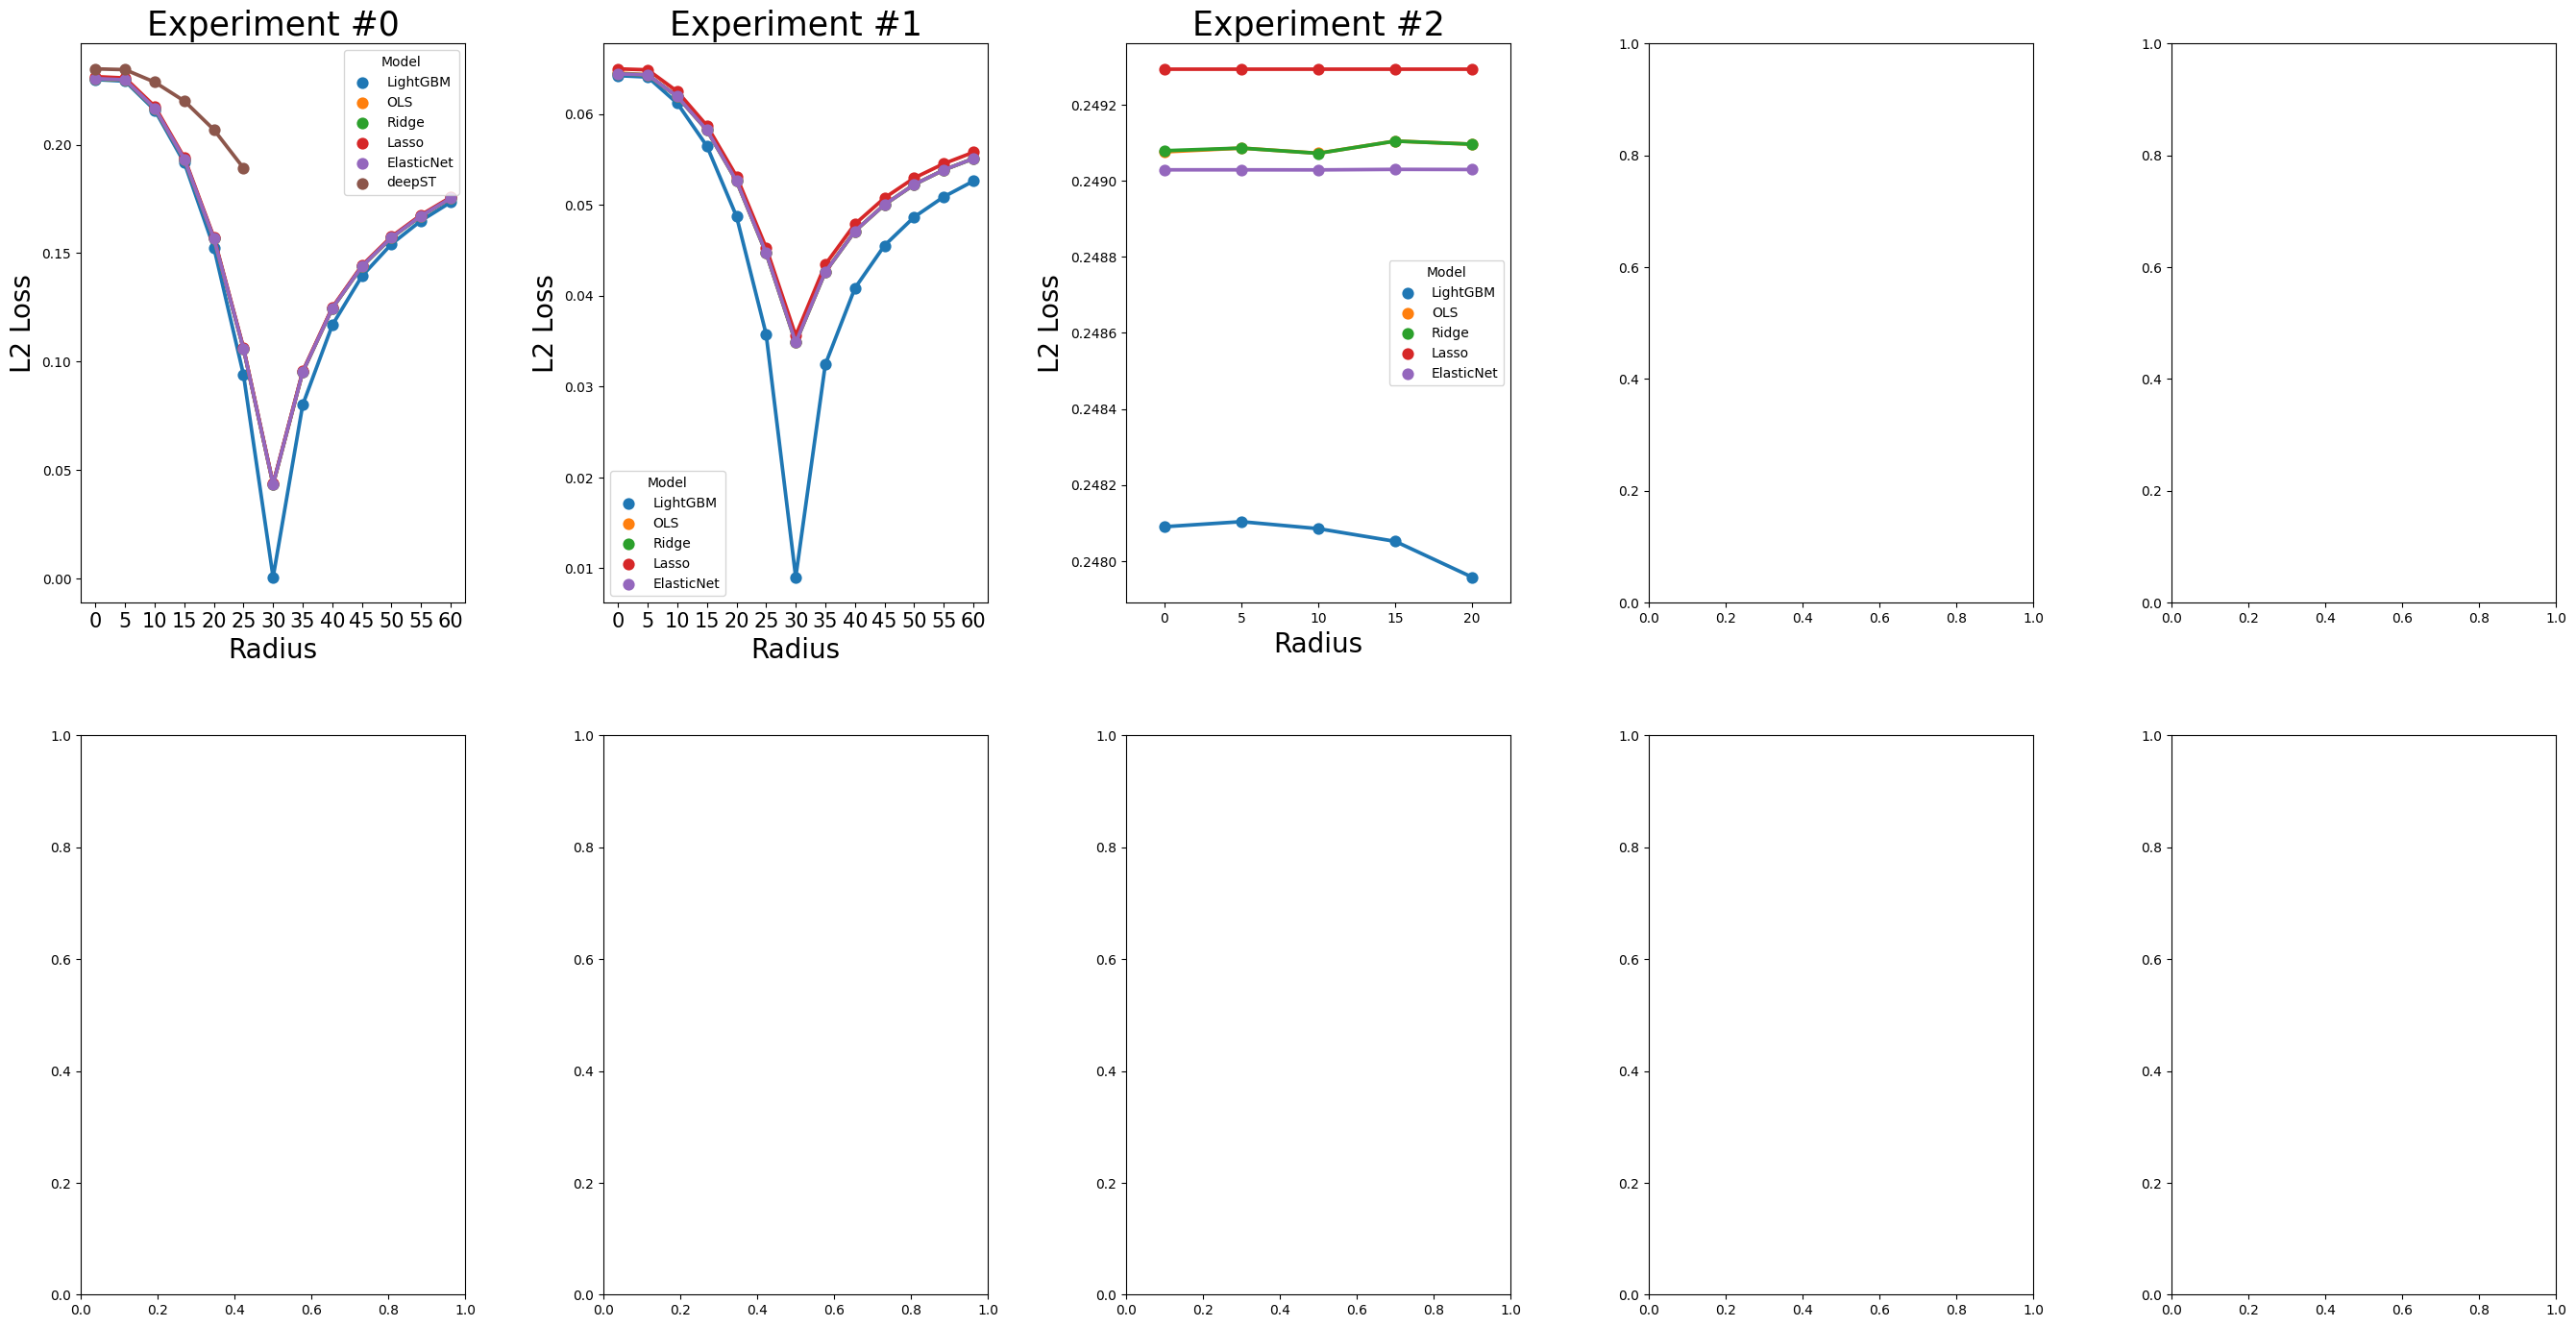

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 5, figsize=(28, 15))

# create pointplot
for exp in range(10):
    new_data = data[data['Experiment #'] == exp]
    synth_results = sns.pointplot(ax=axes[exp // 5, exp % 5], x='Radius', y= 'L2 Loss', hue='Model', data=new_data)
    # baseline = new_data[(new_data["Model"] == "deepST") & (new_data["Radius"] == 0)]["L1 Loss"]
    # synth_results.axhline(baseline.item(), linestyle = '-', linewidth=3)
    synth_results.set_title(f"Experiment #{exp}", fontsize=25)
    synth_results.set_xlabel("Radius", fontsize = 20)
    synth_results.set_ylabel("L2 Loss", fontsize = 20)
    synth_results.set_xticklabels(range(0, 65, 5), fontsize=15)
    fig.tight_layout(pad=5)
plt.savefig(f'synth_experiments.png')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 1, figsize=(18, 18))

# create pointplot
for exp in range(8, 9):
    new_data = data[data['Experiment #'] == exp]
    print(new_data)
    synth_results = sns.pointplot(ax=axes, x='Radius', y= 'L2 Loss', hue='Model', data=new_data)
    # baseline = new_data[(new_data["Model"] == "deepST") & (new_data["Radius"] == 0)]["L1 Loss"]
    # synth_results.axhline(baseline.item(), linestyle = '-', linewidth=3)
    synth_results.set_title(f"Experiment #{exp}", fontsize=25)
    synth_results.set_xlabel("Radius", fontsize = 20)
    synth_results.set_ylabel("L2 Loss", fontsize = 20)
    synth_results.set_xticklabels(range(0, 65, 5), fontsize=15)
plt.savefig(f'synth_experiments.png')